#Assignment 2, CS 6600: Md Mijanur Rahman

Overview:

In this assignment, you will be implementing and analyzing three different machine learning algorithms. Each algorithm will focus on a different problem scenario that can be solved by different learning methods. You must implement all algorithms from scratch using Python and you can use any external libraries such as Sci-kit learn. You can use other libraries for data loading and pre-processing as necessary.

Deliverables:

A single IPython Notebook that contains your code and report. You can use the text cells to write your report and embed any plots, illustrations, and/or images that you need to support your claims.

Due Date:

July 7, 2025

# Dependencies

In [ ]:
# Install required packages
!pip install scikit-learn pandas matplotlib --quiet

In [ ]:
# Import libraries for Problem 1
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from IPython.display import display

# Import libraries for Problem 2
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from google.colab.patches import cv2_imshow
import time

# Problem 1


You are tasked with developing models to predict customer churn for a subscription-based service. Using the provided dataset, your goal is to build two classification models: one using Logistic Regression and the other using Naive Bayes. You will compare their performance, interpret the results, and provide insights into customer churn based on your findings. You will use provided the Telco Customer Churn dataset, which contains customer information such as demographic details, account features, and whether the customer has churned. Your target variable is "Churn," indicating whether a customer has left the service.

Ensure you follow the below instructions:

•
Evaluate both models using the following metrics: Accuracy, Precision, Recall, F1-Score, and ROC-AUC.

•
Perform 5-fold cross-validation on both models and report the averaged results.

•
If there are any missing values (there will be!), fill them in during a pre-processing step using two of the three common strategies outlined below. Do this for the entire dataset!

o
Use the most common value in the dataset that has a value for this feature/attribute

o
Use a default value to fill in for missing values. It can be anything.

o
Drop that feature all together and use only features that have values for all data points.

•
Scale or normalize numerical features if required.



Ensure that your IPython notebook has text files that has the following details:

o
Discuss your outcomes from using your chosen preprocessing steps to handle missing data

o
Compare the performance of both models and discuss their strengths and weaknesses. Which model is more suited for this dataset and why?

o
Insights gained from your experiments

Data Input

In [ ]:
# Load the Telco Customer Churn dataset (Uploaded to Colab Content Folder)
file_path = '/content/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(file_path)

# Display basic info and missing values
df_info = df.info()
missing_values = df.isnull().sum()

df.head(), missing_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


(   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0  7590-VHVEG  Female              0     Yes         No       1           No   
 1  5575-GNVDE    Male              0      No         No      34          Yes   
 2  3668-QPYBK    Male              0      No         No       2          Yes   
 3  7795-CFOCW    Male              0      No         No      45           No   
 4  9237-HQITU  Female              0      No         No       2          Yes   
 
       MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
 0  No phone service             DSL             No  ...               No   
 1                No             DSL            Yes  ...              Yes   
 2                No             DSL            Yes  ...               No   
 3  No phone service             DSL            Yes  ...              Yes   
 4                No     Fiber optic             No  ...               No   
 
   TechSupport StreamingTV StreamingMovies      

Preprocessing Strategies

In [ ]:
# Strategy A (Fill Median): Fill missing values in TotalCharges with the median value (Option 1)
df_A = df.copy()
df_A['TotalCharges'] = pd.to_numeric(df_A['TotalCharges'], errors='coerce')
df_A.fillna({'TotalCharges': df_A['TotalCharges'].median()}, inplace=True)
df_A.drop('customerID', axis=1, inplace=True)

# Strategy B (Drop Column): Drop TotalCharges altogether (Option 3)
df_B = df.copy()
df_B['TotalCharges'] = pd.to_numeric(df_B['TotalCharges'], errors='coerce')
df_B.drop(['TotalCharges', 'customerID'], axis=1, inplace=True)

Preprocessing Function for Both Strategies

In [ ]:
# Common preprocessing function
def preprocess_and_evaluate(df, strategy_label):
    df = df.copy()
    categorical_cols = df.select_dtypes(include='object').columns.tolist()
    categorical_cols.remove('Churn')
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

    numerical = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numerical.remove('Churn')
    scaler = StandardScaler()
    df[numerical] = scaler.fit_transform(df[numerical])

    X = df.drop('Churn', axis=1)
    y = df['Churn']

    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score)
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    lr_model = LogisticRegression(max_iter=1000)
    lr_scores = cross_validate(lr_model, X, y, cv=cv, scoring=scoring)

    nb_model = GaussianNB()
    nb_scores = cross_validate(nb_model, X, y, cv=cv, scoring=scoring)

    def summarize(scores):
        return {metric: np.mean(scores[f'test_{metric}']) for metric in scoring.keys()}

    return {
        'strategy': strategy_label,
        'logistic': summarize(lr_scores),
        'naive_bayes': summarize(nb_scores)
    }

Run Evaluation of Both Models

In [ ]:
# Run evaluations
results_A = preprocess_and_evaluate(df_A, 'Strategy A (Fill Median)')
results_B = preprocess_and_evaluate(df_B, 'Strategy B (Drop Column)')

Display Results and Plotting

In [ ]:
# Define Constraints
metrics_lower = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metrics_cap = [m.capitalize() for m in metrics_lower]
models = ['logistic', 'naive_bayes']

# Data loop for iterating Strategies A and B
data = []
for r in [results_A, results_B]:
    for model in models:
        row = [r['strategy'], model]
        row.extend([r[model][m] for m in metrics_lower])
        data.append(row)

results_df = pd.DataFrame(data, columns=['Strategy', 'Model'] + metrics_cap)

,Strategy,Model,Accuracy,Precision,Recall,F1,Roc_auc
0,Strategy A (Fill Median),logistic,0.805477,0.658972,0.552141,0.600737,0.724563
1,Strategy A (Fill Median),naive_bayes,0.663210,0.433415,0.874786,0.579613,0.730784
2,Strategy B (Drop Column),logistic,0.802211,0.652927,0.542511,0.592522,0.719264
3,Strategy B (Drop Column),naive_bayes,0.657105,0.429137,0.883348,0.577602,0.729364


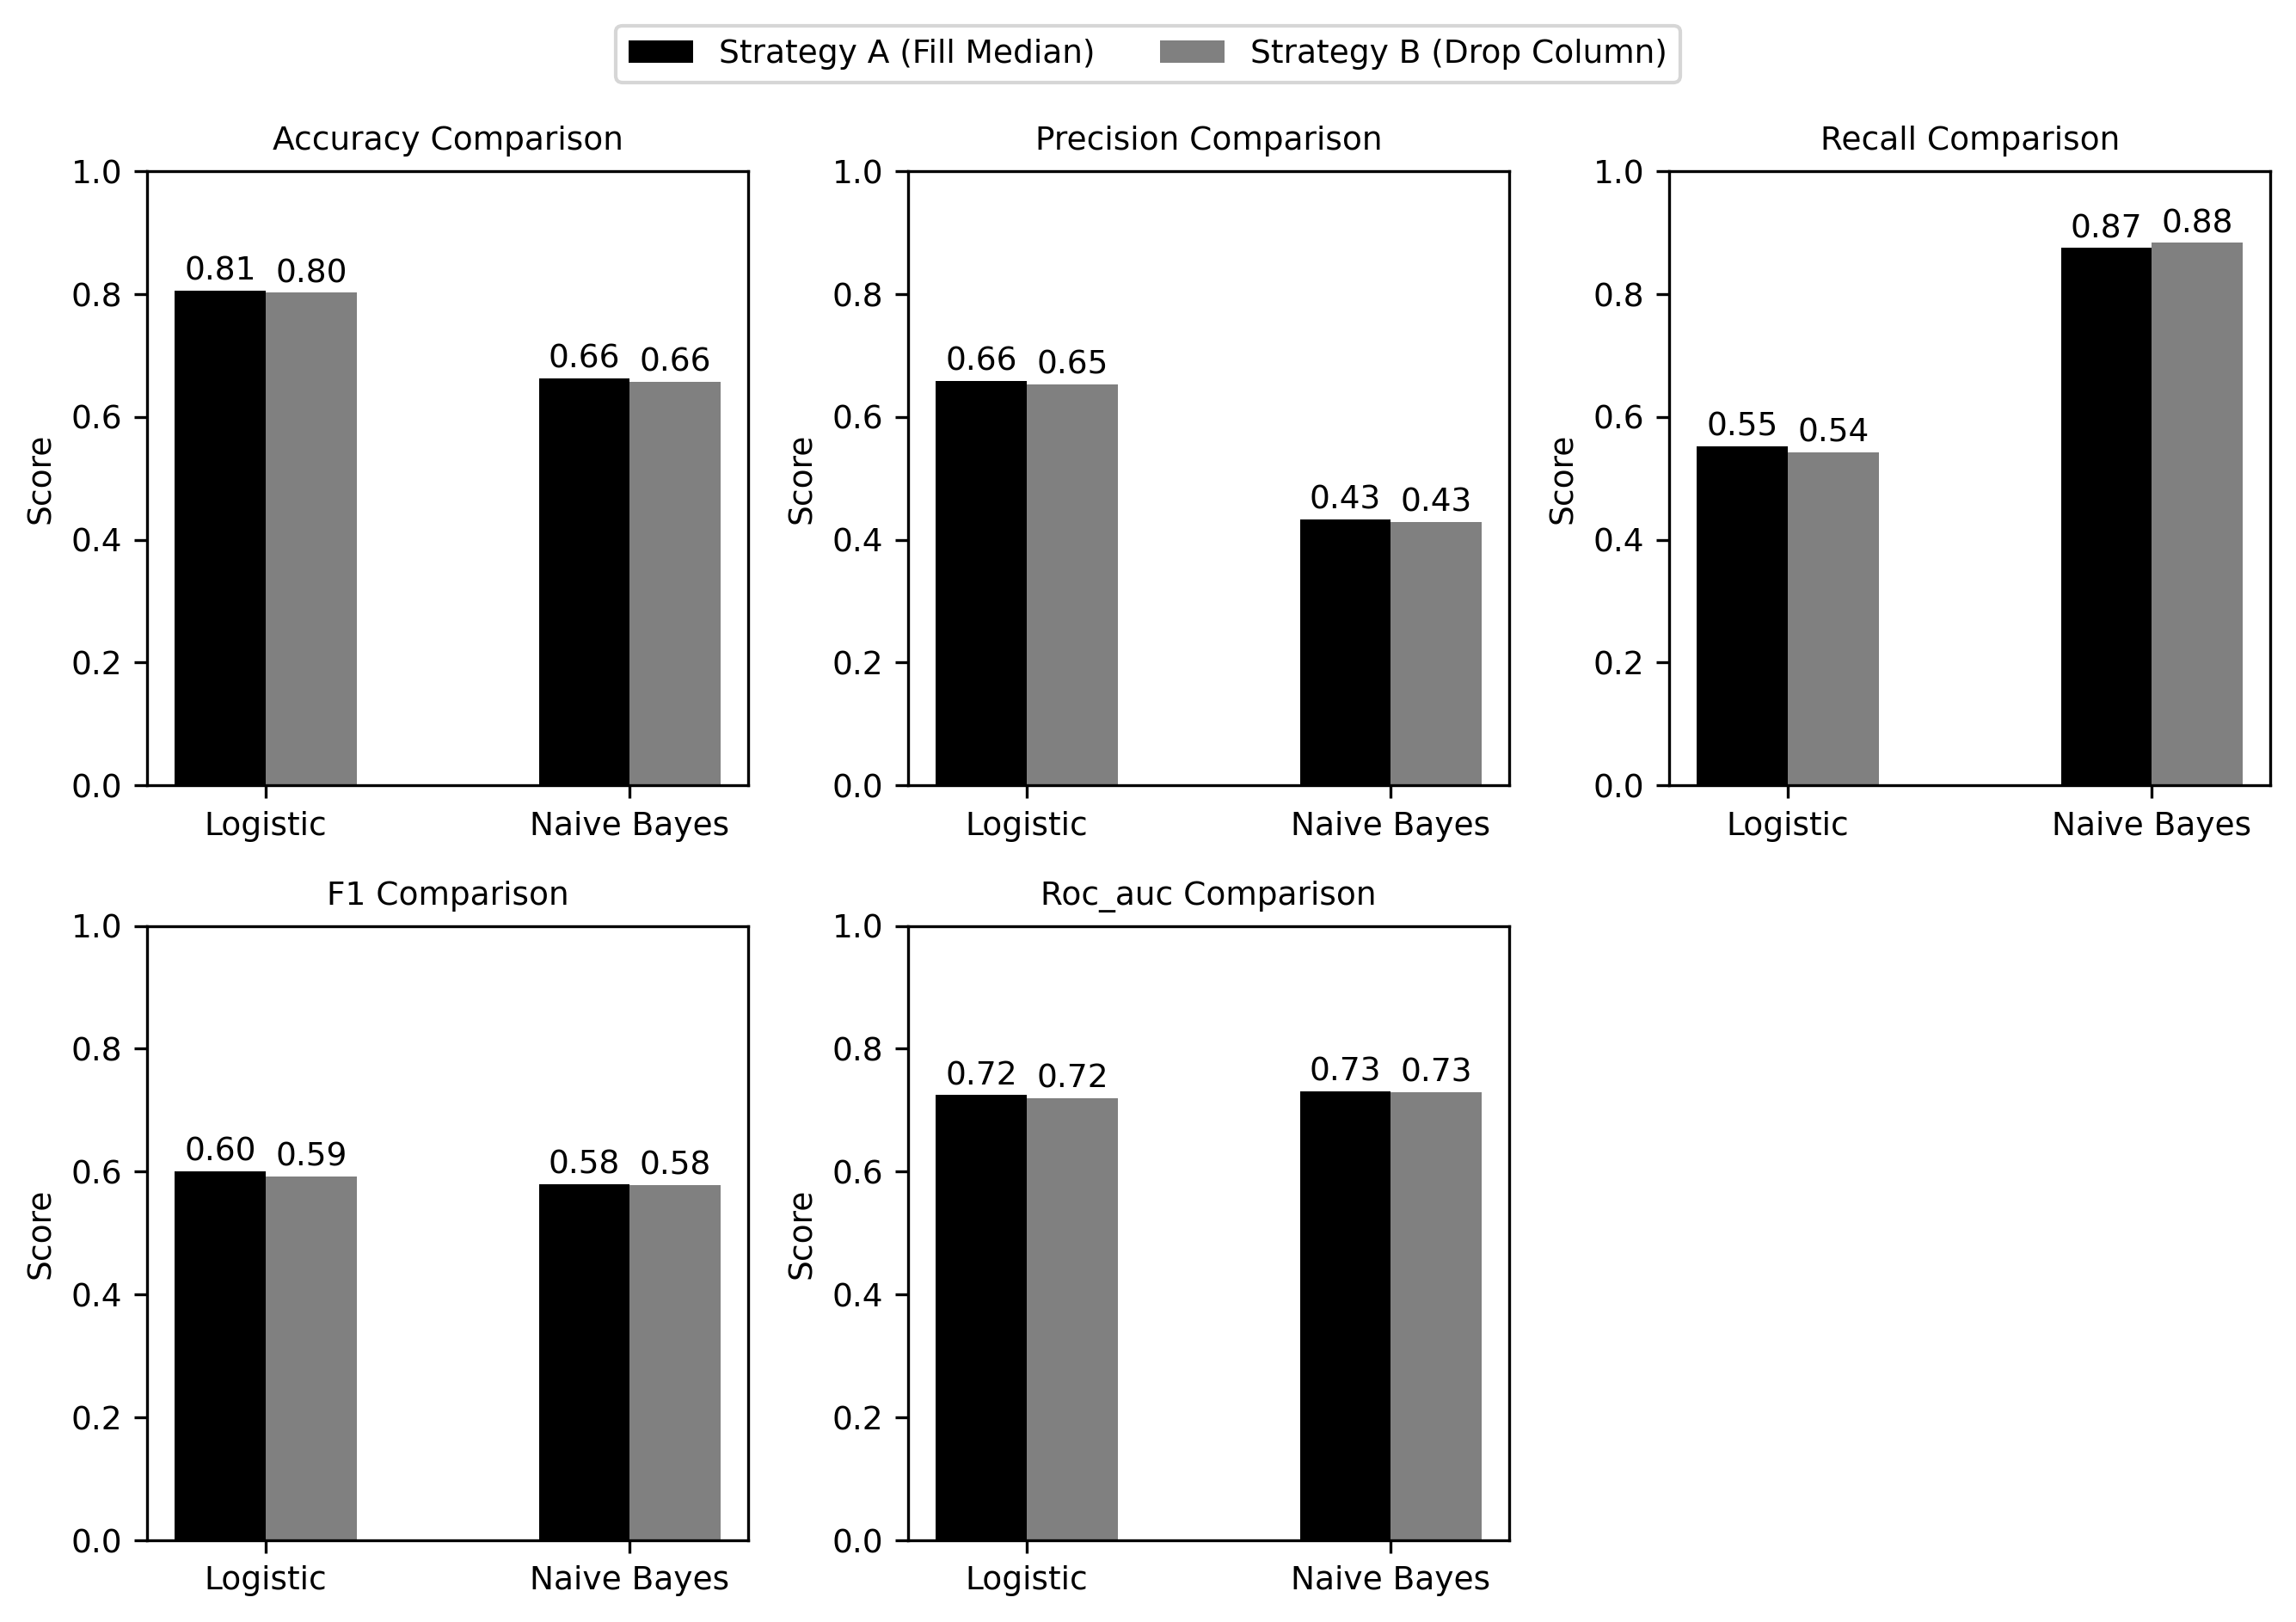

In [ ]:
# Display the results_df table below the plots
display(results_df)

# Plot with unified fontsize
fontsize = 9
fig, axes = plt.subplots(2, 3, figsize=(9, 6), dpi=300)
axes = axes.flatten()
colors = ['black', 'gray']
bar_width = 0.25
x = np.arange(len(models))

for i, metric in enumerate(metrics_cap):
    ax = axes[i]
    values_A = results_df[results_df['Strategy'] == 'Strategy A (Fill Median)'][metric].values
    values_B = results_df[results_df['Strategy'] == 'Strategy B (Drop Column)'][metric].values

    bars1 = ax.bar(x - bar_width/2, values_A, width=bar_width, label='Strategy A (Fill Median)', color=colors[0])
    bars2 = ax.bar(x + bar_width/2, values_B, width=bar_width, label='Strategy B (Drop Column)', color=colors[1])

    ax.set_title(f'{metric} Comparison', fontsize=fontsize)
    ax.set_xticks(x)
    ax.set_xticklabels(['Logistic', 'Naive Bayes'], fontsize=fontsize)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Score", fontsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.grid(False)

    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=fontsize)
    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=fontsize)

# Hide the sixth subplot (bottom right)
fig.delaxes(axes[-1])

# Add one shared legend at the top
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.05), fontsize=fontsize)

plt.tight_layout()

# Show the plot
plt.show()

Report

**Model and Strategy Comparison:**

Logistic Regression consistently outperformed Naive Bayes in terms of Accuracy, Precision, and F1-Score. Naive Bayes exhibited significantly higher Recall, which indicates it correctly identified more churned customers—but at the cost of lower Precision (i.e., more false positives).

Strategy A (Fill Median) performed better across all metrics and models. Strategy B (Drop Column) resulted in a small decline in most performance metrics, particularly for Logistic Regression.

**Insights Gained:**

Logistic Regression strikes a better balance between capturing churned customers and minimizing misclassification. Although Naive Bayes has slightly better ROC-AUC, it sacrifices too much precision.

Retaining the TotalCharges feature by imputing missing values, preserved valuable information.

**Conclusion:**

The best-performing model-strategy pair is: Logistic Regression with Strategy A (Fill Median). Performance details for this model are:

Accuracy: 0.805, Recall: 0.552 (Lower than Naive Bayes), Precision: 0.659, F1-Score: 0.601, ROC_AUC: 0.72 (Slightly lower than Naive Bayes)

# Problem 2

In this question, you will be using k-means to perform image compression. Implement a naïve version of the k-means algorithm based on your understanding. Your code must take the number of clusters k as input and perform k-means clustering on the given image (test_image.png). Once the algorithm finishes running, the cluster centroids represent the top-k common colors in the image. Iterate through each pixel in the image and assign the closest color to each pixel. Save and visualize the resulting image. For reading and writing images, you can use OpenCV, which is an open-source computer vision toolkit. The following code will load the image into a NumPy array. You can use this as input to your K-Means algorithm.

import cv2

img = cv2.imread(‘test_image.png’)

height, width, channels = np.shape(img)

for i in width:

for j in height:

pixel = img[j][i] # Read the pixel at location (i,j)

img[j][i] = newValue # Assign a new value to the pixel

Experiment with different values of k and briefly describe your thoughts about which value works best for this problem. You can use plots, error bars, etc. to support your conclusions.

Data Input

In [ ]:
# Load and preprocess image (Uploaded to Colab Content Folder)
img = cv2.imread('/content/test_image.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height, width, channels = img.shape
pixels = img.reshape((-1, 3))

Compression Function

In [ ]:
def compress_image_kmeans(pixels, k):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pixels)
    centroids = kmeans.cluster_centers_.astype('uint8')
    labels = kmeans.labels_
    compressed_pixels = centroids[labels]
    compressed_img = compressed_pixels.reshape((height, width, 3))
    return compressed_img, centroids, labels

Iterate for Different K Values and Plot Images

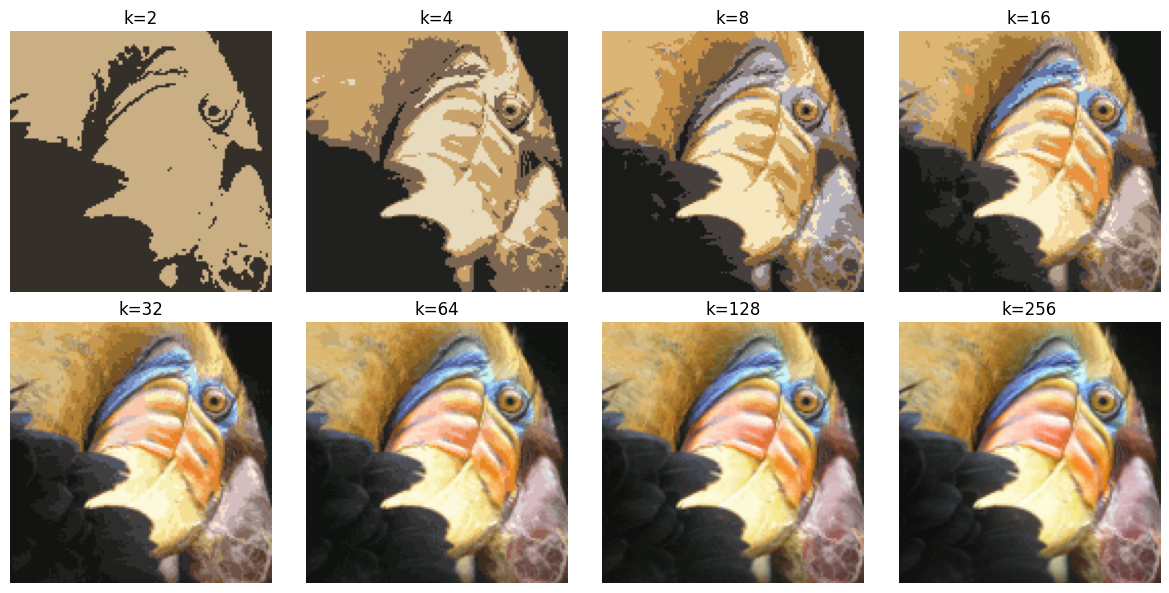

In [ ]:
# Iterate k values
k_values = [2, 4, 8, 16, 32, 64, 128, 256]
errors = []
runtimes = []

# Create subplot grid: 2 rows x 4 columns to fit 8 images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for idx, k in enumerate(k_values):
    start_time = time.time()
    compressed_img, centroids, labels = compress_image_kmeans(pixels, k)
    end_time = time.time()

    runtime = end_time - start_time
    mse = mean_squared_error(pixels, centroids[labels])

    runtimes.append(runtime)
    errors.append(mse)

    axes[idx].imshow(compressed_img)
    axes[idx].set_title(f'k={k}', fontsize=12)
    axes[idx].axis('off')

    # Save compressed image
    cv2.imwrite(f'/content/compressed_k{k}.png', cv2.cvtColor(compressed_img, cv2.COLOR_RGB2BGR))

# Hide the last unused subplot
if len(k_values) < len(axes):
    for idx in range(len(k_values), len(axes)):
        fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


Barchart for Performance Comparison and Deciding Optimal K

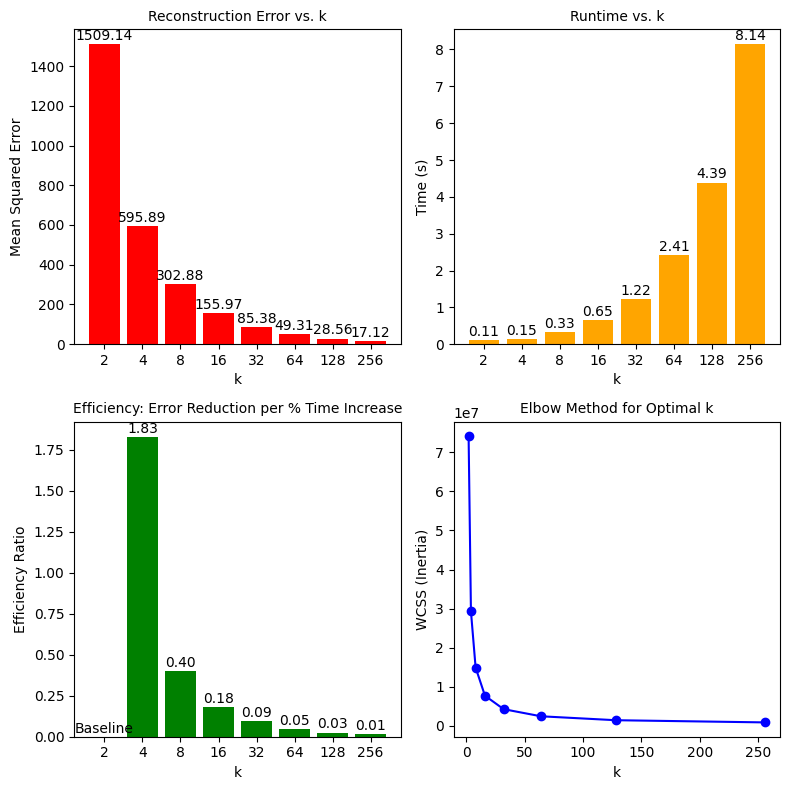

In [ ]:
# Convert to NumPy arrays
errors = np.array(errors)
runtimes = np.array(runtimes)

# Baseline values
baseline_error = errors[0]
baseline_time = runtimes[0]

# Efficiency calculations
percent_error_reduction = 100 * (baseline_error - errors) / baseline_error
percent_time_increase = 100 * (runtimes - baseline_time) / baseline_time
percent_time_increase[0] = 1e-6  # Avoid division by zero
efficiency = percent_error_reduction / percent_time_increase

# Inertia for Elbow method
inertia = []
for k in k_values:
    km = KMeans(n_clusters=k, n_init=10)
    km.fit(pixels)
    inertia.append(km.inertia_)

# Plot all four in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fontsize = 10

# Plot 1: Error vs k
bars1 = axes[0, 0].bar([str(k) for k in k_values], errors, color='red')
axes[0, 0].set_title("Reconstruction Error vs. k", fontsize=fontsize)
axes[0, 0].set_xlabel("k", fontsize=fontsize)
axes[0, 0].set_ylabel("Mean Squared Error", fontsize=fontsize)
axes[0, 0].tick_params(axis='both', labelsize=fontsize)
for bar in bars1:
    height = bar.get_height()
    axes[0, 0].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords='offset points', ha='center', fontsize=fontsize)

# Plot 2: Runtime vs k
bars2 = axes[0, 1].bar([str(k) for k in k_values], runtimes, color='orange')
axes[0, 1].set_title("Runtime vs. k", fontsize=fontsize)
axes[0, 1].set_xlabel("k", fontsize=fontsize)
axes[0, 1].set_ylabel("Time (s)", fontsize=fontsize)
axes[0, 1].tick_params(axis='both', labelsize=fontsize)
for bar in bars2:
    height = bar.get_height()
    axes[0, 1].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords='offset points', ha='center', fontsize=fontsize)

# Plot 3: Efficiency
bars3 = axes[1, 0].bar([str(k) for k in k_values], efficiency, color='green')
axes[1, 0].set_title("Efficiency: Error Reduction per % Time Increase", fontsize=fontsize)
axes[1, 0].set_xlabel("k", fontsize=fontsize)
axes[1, 0].set_ylabel("Efficiency Ratio", fontsize=fontsize)
axes[1, 0].tick_params(axis='both', labelsize=fontsize)
for i, bar in enumerate(bars3):
    height = bar.get_height()
    label = "Baseline" if k_values[i] == 2 else f'{height:.2f}'
    axes[1, 0].annotate(label, xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords='offset points', ha='center', fontsize=fontsize)

# Plot 4: Elbow Curve
axes[1, 1].plot(k_values, inertia, marker='o', color='blue')
axes[1, 1].set_title("Elbow Method for Optimal k", fontsize=fontsize)
axes[1, 1].set_xlabel("k", fontsize=fontsize)
axes[1, 1].set_ylabel("WCSS (Inertia)", fontsize=fontsize)
axes[1, 1].tick_params(axis='both', labelsize=fontsize)

plt.tight_layout()
plt.show()

Report

This problem focused on applying color quantization using k-means clustering to compress an image and evaluate how varying the number of clusters k impacts reconstruction error, runtime, and efficiency. The goal was to identify an optimal value of k that achieves a good trade-off between image quality and computational cost.

The reconstruction error decreases rapidly as the number of clusters \( k \) increases, dropping from 1509.14 at \( k = 2 \) to just 17.12 at \( k = 256 \). However from visual assessment, beyond \( k = 32 \), further gains in quality become barely noticable. So, from \( k = 64 \) and onwards, we can see diminishing returns in terms of error reduction.

In terms of runtime, the algorithm remains relatively fast up to \( k = 4 \), with only slight increase in processing time when compared to \( k = 4 \). After that, the runtime almost doubles as the value of \( k \) doubles. Finally, the processing time reaches 8.14 seconds at \( k = 256 \), which may be computationally expensive depending on the application.

Efficiency, defined as the percentage of error reduction per percentage of runtime increase, peaks at \( k = 4 \) with a value of 1.83 when compared to the baseline value for \( k = 2 \) . This means that \( k = 4 \) offers the most cost-effective improvement in quality. Beyond this point, efficiency drops sharply, and values higher than \( k = 32 \) yield only marginal improvements in error at a high computational cost.

The elbow method, based on the Within-Cluster Sum of Squares (WCSS), shows a clear inflection point between \( k = 16 \) and \( k = 32 \), suggesting that this is the optimal range for balancing cluster compactness and model complexity.

In conclusion, a value of \( k = 32 \) provides the best balance between image reconstruction quality, efficiency, and runtime. If computational speed is a priority, \( k = 4 \) is ideal. For high-fidelity applications where quality matters more than speed, \( k = 64 \) may be be a suitable choice. Higher values of \( k \) from 128 onwards do not justify the high computational cost due to their highly diminished return interms of image reconstruction quality.
